In [1]:
import yfinance as yf
import pandas as pd
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def fetch_data(tickers, start=None, end=None):
    import datetime

    # Use default dates if user does not provide them
    if not start:
        start = "2020-01-01"
    if not end:
        end = datetime.datetime.today().strftime("%Y-%m-%d")

    data = yf.download(tickers, start=start, end=end, group_by='ticker', auto_adjust=True)

    # Handle both single and multi-level column format
    if isinstance(data.columns, pd.MultiIndex):
        try:
            adj_close = data.xs('Close', level=1, axis=1)
        except KeyError:
            raise ValueError("❌ 'Adj Close' prices not found — possibly all tickers failed.")
    else:
        if 'Close' in data.columns:
            adj_close = data['Close'].to_frame()
        else:
            raise ValueError("❌ No 'Adj Close' in single-column format.")

    # Drop tickers with no data
    adj_close = adj_close.dropna(axis=1, how='all')

    # ✅ Detect failed tickers
    successful = list(adj_close.columns)
    failed = [t for t in tickers if t not in successful]

    if not successful:
        raise ValueError("❌ Tickers failed to download.")
    
    if failed:
        print(f"\n⚠️ The following tickers failed to download (check for typos or delisting): {failed}")

    returns = adj_close.pct_change().dropna()
    return adj_close, returns

def optimize_portfolio(expected_returns, cov_matrix, risk_aversion=1.0):
    """
    Mean-variance optimization using cvxpy.
    Ensures portfolio weights sum to 1 and are non-negative.
    """
    n = len(expected_returns)
    w = cp.Variable(n)
    mu = expected_returns.values
    Sigma = cov_matrix.values

    # Objective: maximize return - risk penalty
    objective = cp.Maximize(mu @ w - risk_aversion * cp.quad_form(w, Sigma))

    # Constraints: weights sum to 1, weights ≥ 0 (no shorting)
    constraints = [cp.sum(w) == 1, w >= 0]
    # Solve
    prob = cp.Problem(objective, constraints)
    prob.solve()
    weights = w.value
    threshold = 1e-4
    weights[np.abs(weights) < threshold] = 0 # eliminate tiny negative weights like -1e-20
    weights = weights / weights.sum()  # renormalize to sum to 1
    return weights


def plot_portfolio_weights(weights, labels):
    # 🔍 Filter out tiny or zero weights
    weights = np.array(weights)
    threshold=1e-4
    non_zero_indices = np.where(weights > threshold)[0]
    filtered_weights = weights[non_zero_indices]
    filtered_labels = [f"[{tickers[i]}]" for i in non_zero_indices]

    # 🥧 Plot
    plt.figure(figsize=(6, 6))
    patches, texts, autotexts = plt.pie(
        filtered_weights,
        labels=filtered_labels,
        autopct='%1.3f%%',
        startangle=90,
        counterclock=False
    )
    plt.title("Optimal Portfolio Allocation", fontsize=14, fontweight='bold', pad=20)

    # ✨ Style text
    for text in texts + autotexts:
        text.set_fontsize(10)

    plt.axis('equal')
    plt.tight_layout(pad=2)
    plt.show()

def plot_portfolio_growth(portfolio_returns):
    cumulative = (1 + portfolio_returns).cumprod()

    plt.figure(figsize=(10, 5))
    plt.plot(cumulative, linewidth=2, color='green')
    plt.title("Portfolio Cumulative Return", fontsize=14, fontweight='bold')
    plt.xlabel("Date")
    plt.ylabel("Portfolio Value (Normalized)")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

def plot_efficient_frontier(mu, cov, points=50):
    n = len(mu)
    risks, rets = [], []

    for gamma in np.logspace(-1, 3, points):
        w = cp.Variable(n)
        objective = cp.Maximize(mu @ w - gamma * cp.quad_form(w, cov))
        constraints = [cp.sum(w) == 1, w >= 0]
        cp.Problem(objective, constraints).solve()
        w_val = w.value
        risks.append(np.sqrt(w_val.T @ cov @ w_val))
        rets.append(mu @ w_val)

    plt.figure(figsize=(8, 5))
    plt.plot(risks, rets, marker='o')
    plt.title("Efficient Frontier")
    plt.xlabel("Volatility (Risk)")
    plt.ylabel("Expected Return")
    plt.grid(True)
    plt.show()

In [3]:
#Step 1: Input tickers, start and end date
tickers = input("Enter tickers (comma separated): ").split(",")
start_date = input("Enter start date (YYYY-MM-DD): ")
end_date = input("Enter end date (YYYY-MM-DD): ")
tickers = [t.strip().upper() for t in tickers]

# Step 2: Fetch data

adj_close, returns = fetch_data(tickers, start=start_date, end=end_date)

# Step 3: Compute metrics
expected_returns = returns.mean() * 252
cov_matrix = returns.cov() * 252
cov_matrix = (cov_matrix + cov_matrix.T) / 2  # Force symmetry

#Step 4: Optimize
optimal_weights = optimize_portfolio(expected_returns, cov_matrix, risk_aversion=1.0)

#Step 5: Display results
result = pd.DataFrame({
    'Ticker': tickers,
    'Optimal Weight': optimal_weights
})
print("\nOptimal Portfolio Allocation:")
print(result)
print("\nSum of weights:", round(optimal_weights.sum(), 4))
print("Are any weights negative?", (optimal_weights < 0).any())



Enter tickers (comma separated):  GOOG,MSFT,TSLA
Enter start date (YYYY-MM-DD):  2022-01-01
Enter end date (YYYY-MM-DD):  2025-01-01


[*********************100%***********************]  3 of 3 completed


Optimal Portfolio Allocation:
  Ticker  Optimal Weight
0   GOOG        0.383761
1   MSFT        0.094822
2   TSLA        0.521417

Sum of weights: 1.0
Are any weights negative? False


In [4]:
#Expected Portfolio Return
port_return = np.dot(optimal_weights, expected_returns) 

#Portfolio Risk (Volatility)
port_volatility = np.sqrt(optimal_weights.T @ cov_matrix.values @ optimal_weights) 

#Sharpe Ratio (assume risk-free=0%)
sharpe_ratio = port_return / port_volatility 

print(f"\nExpected Return: {port_return:.2%}")
print(f"Volatility (Risk): {port_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")




Expected Return: 13.86%
Volatility (Risk): 27.91%
Sharpe Ratio: 0.50


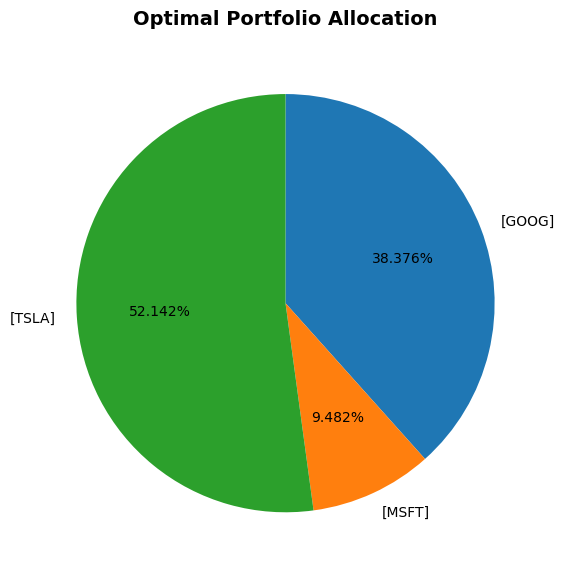

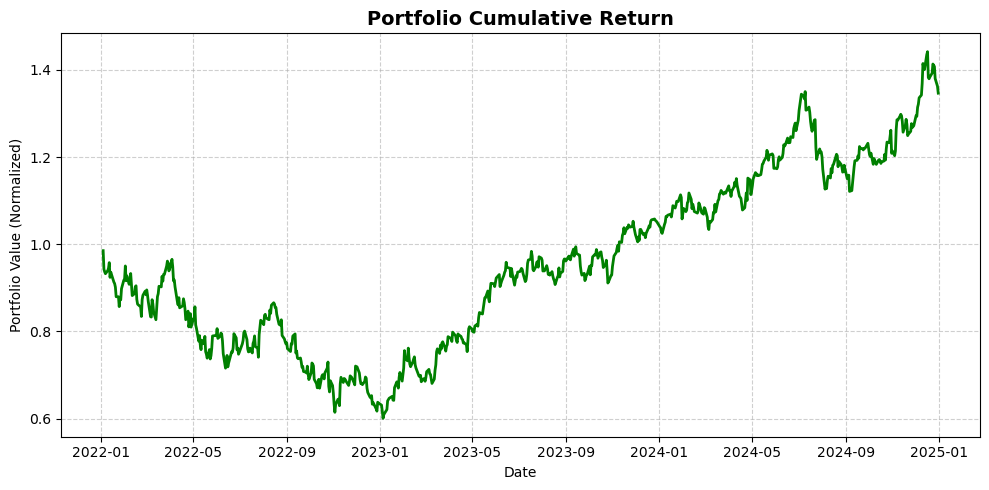

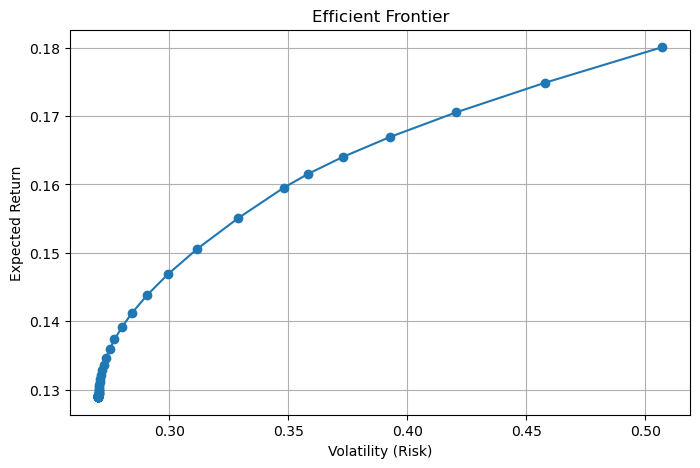

In [5]:
# 🔥 Plot portfolio weight distribution
plot_portfolio_weights(optimal_weights, result['Ticker'])

# 📈 Plot portfolio growth over time
portfolio_returns = (returns @ optimal_weights).dropna()
plot_portfolio_growth(portfolio_returns)

# 📈 Plot Efficient Frontier
plot_efficient_frontier(expected_returns.values, cov_matrix.values)